In [47]:
import pygplates
import pandas
import pygmt
import numpy as np
from gprm import PointDistributionOnSphere
from gprm.datasets import Reconstructions


In [14]:
P2015 = Reconstructions.fetch_Pehrsson2015()

random_points = PointDistributionOnSphere(N=2000)

In [14]:
assigned_point_features = pygplates.partition_into_plates(
            P2015.static_polygons,
            P2015.rotation_model,
            random_points.meshnode_feature,
            properties_to_copy = [pygplates.PartitionProperty.reconstruction_plate_id])


fig = pygmt.Figure()

fig.basemap(frame='afg', region='d', projection='N6i')
fig.coast(land='grey')
pygmt.makecpt(cmap='magma', series=[0,1000,1])
for feature in assigned_point_features:
    if feature.get_reconstruction_plate_id() != 0:
        geom = feature.get_geometry().to_lat_lon_array()
        fig.plot(x=geom[:,1], y=geom[:,0],
                 style='c0.05c', pen='1p', cmap=True, zvalue=feature.get_reconstruction_plate_id())
fig.basemap(frame='afg')

fig.show(width=900)

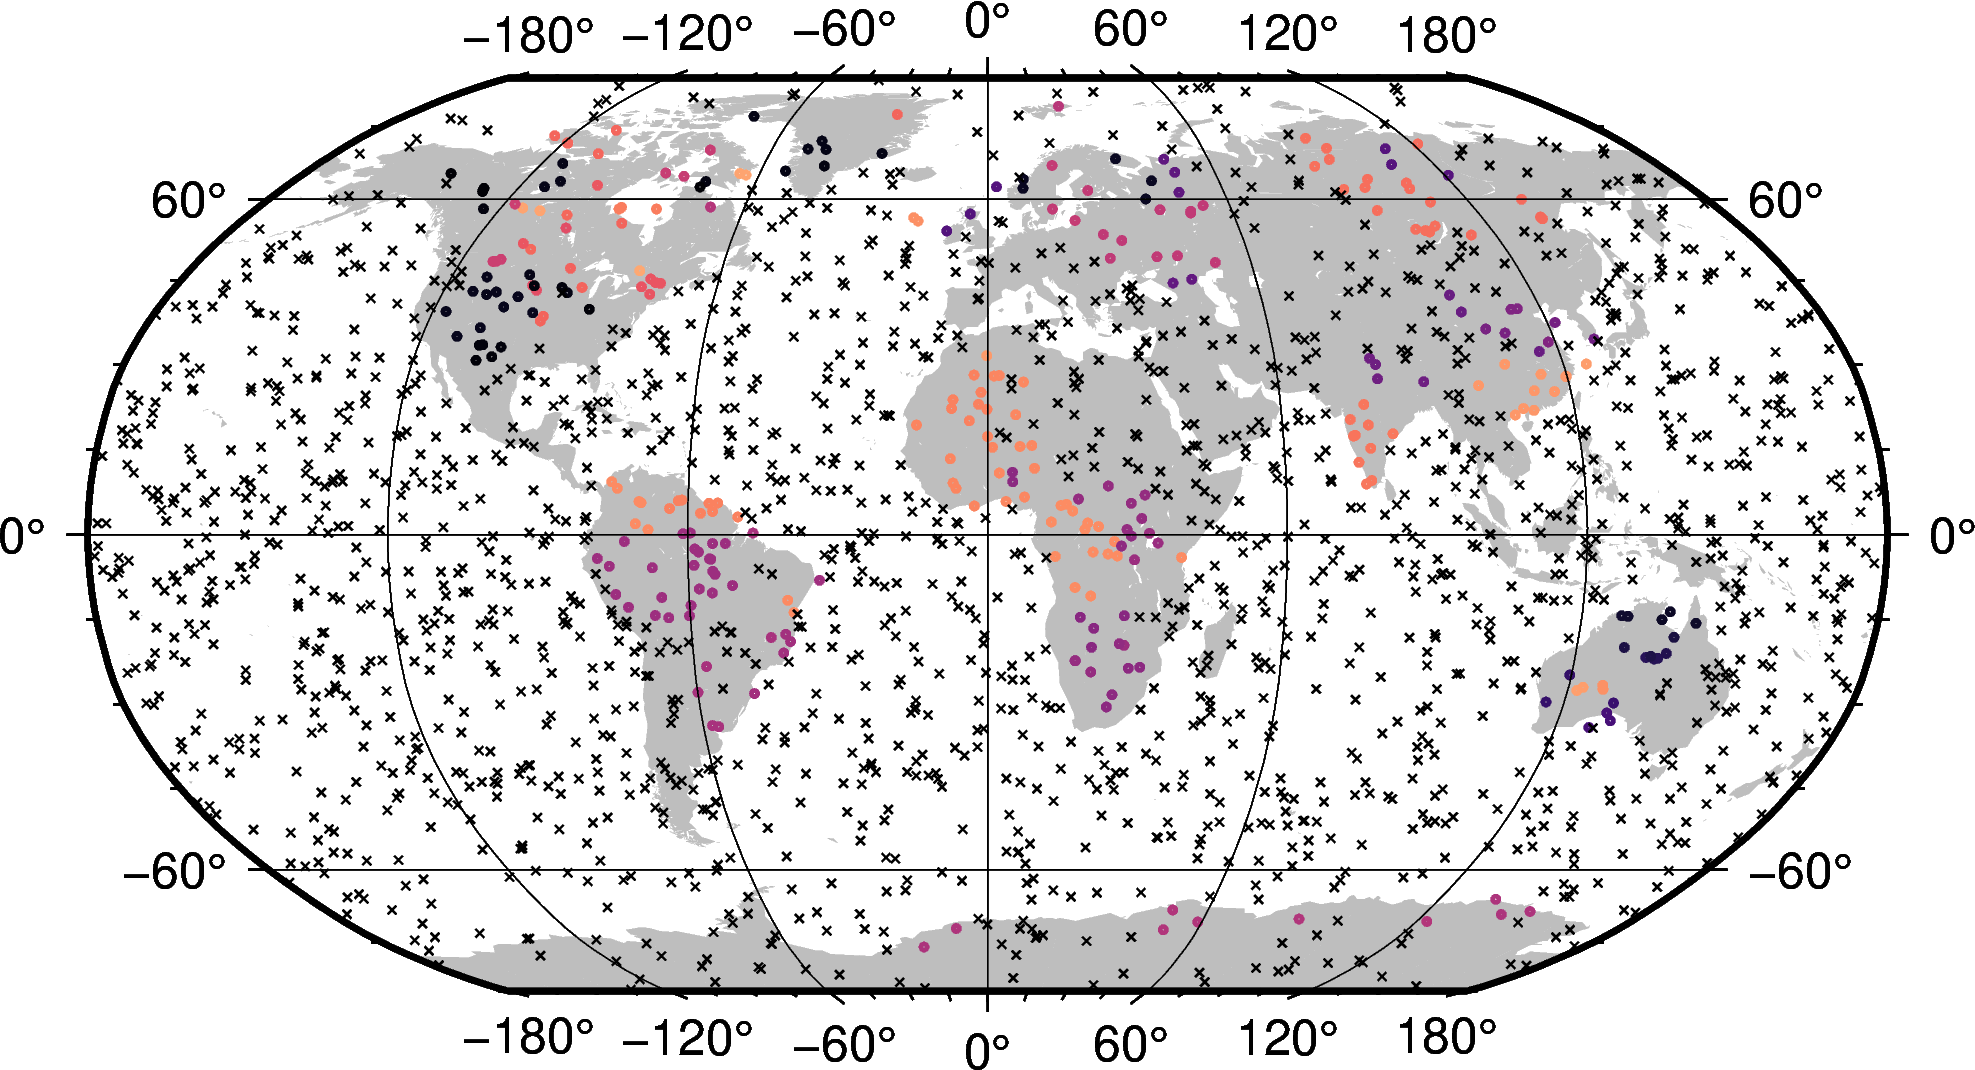

In [25]:
(assigned_point_features,
 unpartitioned_features) = pygplates.partition_into_plates(
            P2015.static_polygons,
            P2015.rotation_model,
            random_points.meshnode_feature,
            properties_to_copy = [pygplates.PartitionProperty.reconstruction_plate_id],
            partition_return = pygplates.PartitionReturn.separate_partitioned_and_unpartitioned)


fig = pygmt.Figure()

fig.basemap(frame='afg', region='d', projection='N6i')
fig.coast(land='grey')
pygmt.makecpt(cmap='magma', series=[0,1000,1])
for feature in assigned_point_features:
    geom = feature.get_geometry().to_lat_lon_array()
    fig.plot(x=geom[:,1], y=geom[:,0],
             style='c0.05c', pen='1p', cmap=True, zvalue=feature.get_reconstruction_plate_id())
for feature in unpartitioned_features:
    geom = feature.get_geometry().to_lat_lon_array()
    fig.plot(x=geom[:,1], y=geom[:,0],
             style='x0.1c', pen='0.5p,black')  
fig.basemap(frame='afg')

fig.show(width=900)


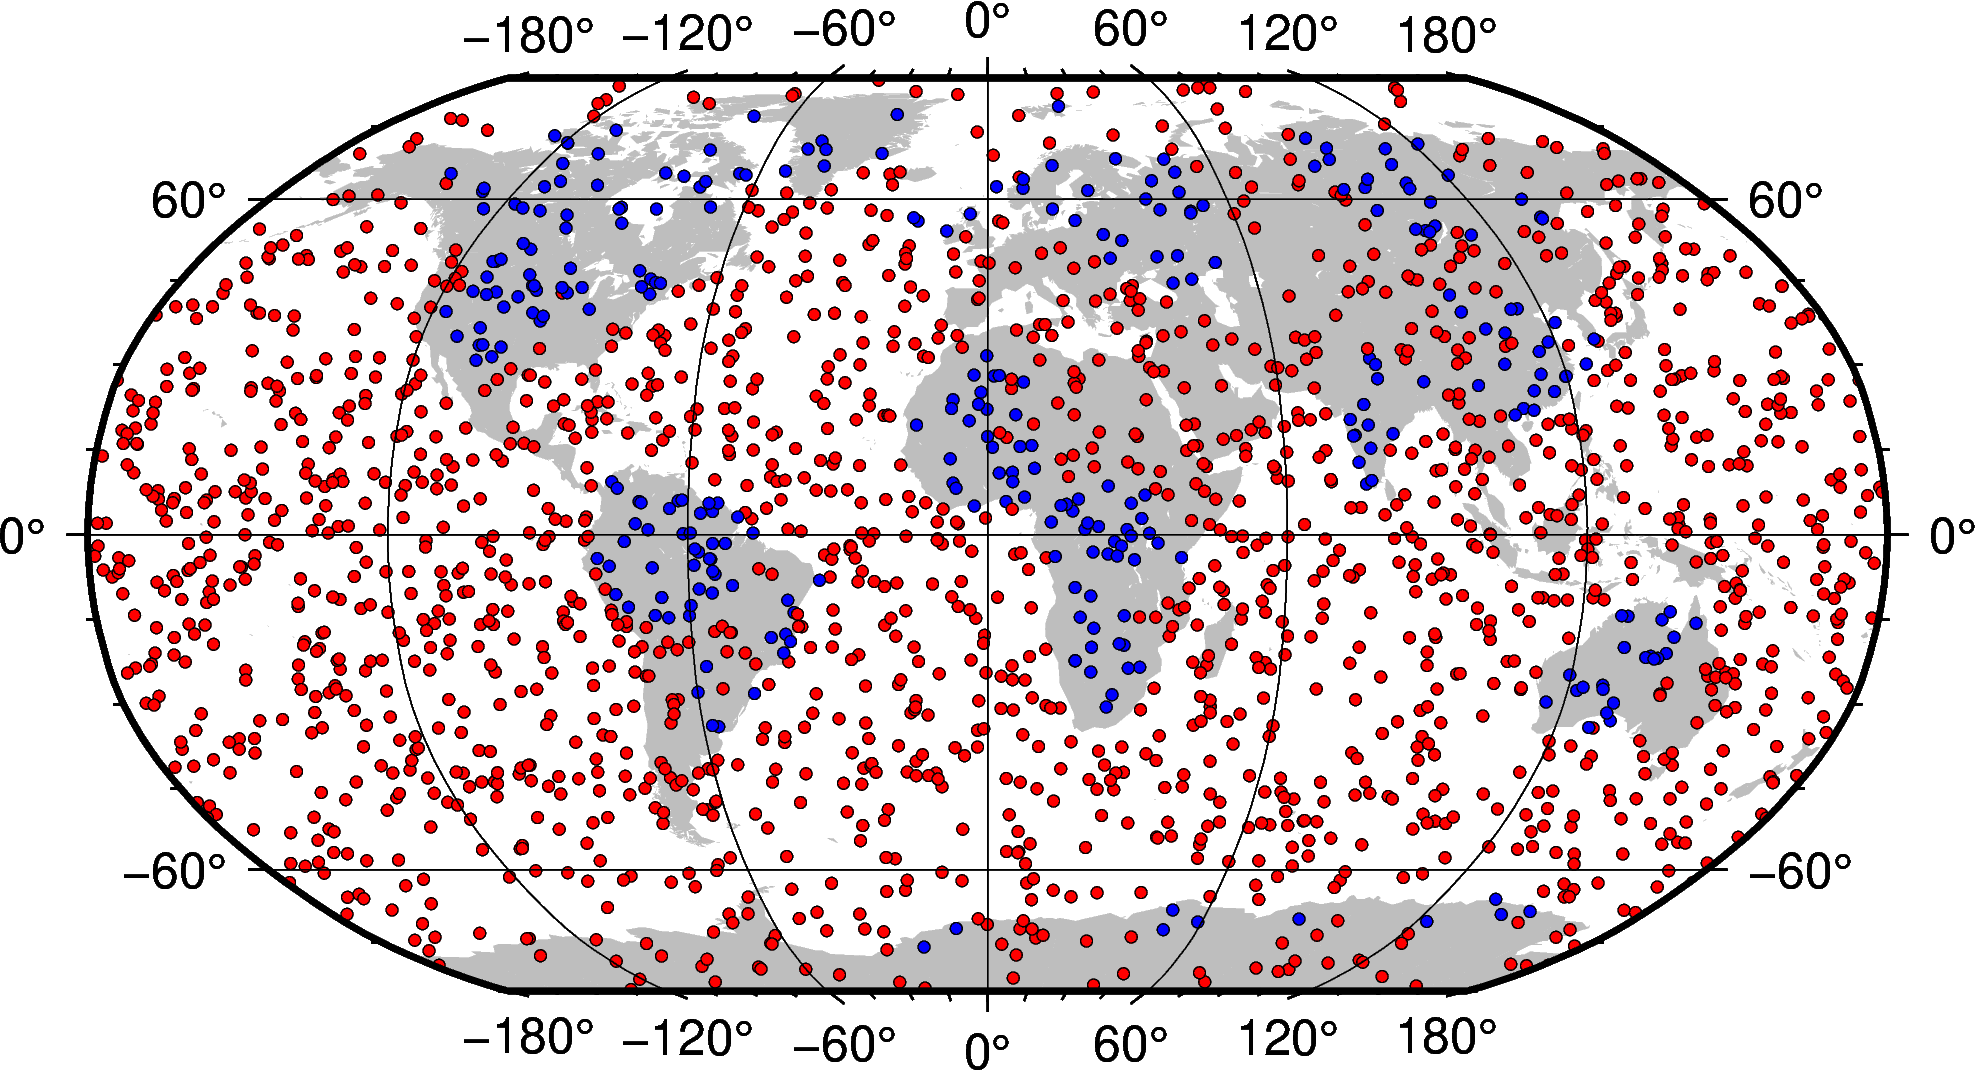

In [54]:
from ptt.utils import points_in_polygons

points = random_points.multipoint.get_points()

polygons = []
for feature in pygplates.FeatureCollection(P2015.static_polygon_files[0]):
    for polygon in feature.get_all_geometries():
        polygons.append(polygon)

polygons_containing_points = points_in_polygons.find_polygons(points, polygons)

#print(polygons_containing_points)

#'''
lat = []
lon = []
zval = []
for pcp,point in zip(polygons_containing_points,points):
    lat.append(point.to_lat_lon()[0])
    lon.append(point.to_lat_lon()[1])
    if pcp is not None:
        zval.append(1)
    else:
        zval.append(0)


fig = pygmt.Figure()

fig.basemap(frame='afg', region='d', projection='N6i')
fig.coast(land='grey')
pygmt.makecpt(cmap='red,blue', series=[0,1])
fig.plot(x=lon, y=lat,
         style='c0.1c', pen='0.2p', cmap=True, color=zval)

fig.basemap(frame='afg')

fig.show(width=900)